In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models

# ================================
# 1️⃣ 기본 설정
# ================================
NAVER_ROOT_DIR = "/content/drive/MyDrive/Naver_Processed"
OUTPUT_MODEL_PATH = "/content/drive/MyDrive/Webtoon_Models/webtoon_resnet50_bundle.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ================================
# 2️⃣ Dataset 정의 (bundle 폴더 무시)
# ================================
class WebtoonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        for work_id in os.listdir(root_dir):
            work_path = os.path.join(root_dir, work_id)
            if not os.path.isdir(work_path):
                continue
            for bundle in os.listdir(work_path):
                bundle_path = os.path.join(work_path, bundle)
                if not os.path.isdir(bundle_path):
                    continue
                for fname in os.listdir(bundle_path):
                    if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                        self.samples.append((os.path.join(bundle_path, fname), work_id))
        self.classes = sorted(list({label for _, label in self.samples}))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_idx = self.class_to_idx[label]
        return img, label_idx

# ================================
# 3️⃣ Transform
# ================================
transform_train = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.RandomResizedCrop(320, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_val = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# ================================
# 4️⃣ Dataset 및 DataLoader
# ================================
full_dataset = WebtoonDataset(NAVER_ROOT_DIR, transform=transform_train)

# train/val/test 자동 분할
total = len(full_dataset)
indices = list(range(total))
random.shuffle(indices)

test_size = int(0.2 * total)
val_size = int(0.2 * total)
train_size = total - test_size - val_size

train_dataset = Subset(full_dataset, indices[:train_size])
val_dataset = Subset(full_dataset, indices[train_size:train_size + val_size])
test_dataset = Subset(full_dataset, indices[train_size + val_size:])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

num_classes = len(full_dataset.classes)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}, Classes: {num_classes}")

# ================================
# 5️⃣ 모델 정의 (ResNet50 + Gradual Unfreeze)
# ================================
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_features, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# ================================
# 6️⃣ 학습 루프
# ================================
best_acc = 0.0
EPOCHS = 20

for epoch in range(1, EPOCHS + 1):
    # Gradual unfreeze
    if epoch == 1:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
    elif epoch == 5:
        for name, param in model.named_parameters():
            if "layer4" in name or "fc" in name:
                param.requires_grad = True
    elif epoch == 10:
        for param in model.parameters():
            param.requires_grad = True

    # ---- Training ----
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = train_correct / total
    train_loss /= total

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = val_correct / total
    val_loss /= total

    print(f"Epoch [{epoch}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), OUTPUT_MODEL_PATH)
        print(f"✅ Best model saved at epoch {epoch} (Val Acc: {val_acc*100:.2f}%)")

# ================================
# 7️⃣ 테스트
# ================================
model.load_state_dict(torch.load(OUTPUT_MODEL_PATH))
model.eval()

test_correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = test_correct / total
print(f"🎯 최종 Test Accuracy: {test_acc*100:.2f}%")
print(f"모델 저장 위치: {OUTPUT_MODEL_PATH}")


Device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Train: 16722, Val: 5574, Test: 5574, Classes: 340
Epoch [1/20] | Train Loss: 5.7794 | Train Acc: 1.02% | Val Loss: 5.6565 | Val Acc: 1.49%
✅ Best model saved at epoch 1 (Val Acc: 1.49%)
Epoch [2/20] | Train Loss: 5.5986 | Train Acc: 1.94% | Val Loss: 5.5263 | Val Acc: 2.42%
✅ Best model saved at epoch 2 (Val Acc: 2.42%)
Epoch [3/20] | Train Loss: 5.4660 | Train Acc: 3.07% | Val Loss: 5.4145 | Val Acc: 4.18%
✅ Best model saved at epoch 3 (Val Acc: 4.18%)
Epoch [4/20] | Train Loss: 5.3442 | Train Acc: 4.37% | Val Loss: 5.3182 | Val Acc: 4.29%
✅ Best model saved at epoch 4 (Val Acc: 4.29%)
Epoch [5/20] | Train Loss: 4.4738 | Train Acc: 12.92% | Val Loss: 3.9861 | Val Acc: 20.47%
✅ Best model saved at epoch 5 (Val Acc: 20.47%)
Epoch [6/20] | Train Loss: 3.6318 | Train Acc: 25.15% | Val Loss: 3.3977 | Val Acc: 27.74%
✅ Best model saved at epoch 6 (Val Acc: 27.74%)
Epoch [7/20] | Train Loss: 3.0483 | Train Acc: 35.32% | Val Loss: 3.0265 | Val Acc: 35.04%
✅ Best model saved at epoch 7 (Val Ac

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models

# ================================
# 1️⃣ 기본 설정
# ================================
NAVER_ROOT_DIR = "/content/drive/MyDrive/Naver_Processed"
PRETRAINED_PATH = "/content/drive/MyDrive/Webtoon_Models/webtoon_resnet50_bundle.pt"
OUTPUT_MODEL_PATH = "/content/drive/MyDrive/Webtoon_Models/webtoon_resnet50_v2.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ================================
# 2️⃣ Dataset
# ================================
class WebtoonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []

        for work_id in os.listdir(root_dir):
            work_path = os.path.join(root_dir, work_id)
            if not os.path.isdir(work_path):
                continue

            for bundle in os.listdir(work_path):
                bundle_path = os.path.join(work_path, bundle)
                if not os.path.isdir(bundle_path):
                    continue

                for fname in os.listdir(bundle_path):
                    if fname.lower().endswith(('.jpg','.png','.jpeg')):
                        self.samples.append((os.path.join(bundle_path, fname), work_id))

        self.classes = sorted(list({label for _, label in self.samples}))
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.class_to_idx[label]

# ================================
# 3️⃣ Transform
# ================================
transform_train = transforms.Compose([
    transforms.Resize((384,384)),
    transforms.RandomResizedCrop(384, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.2,0.2,0.2,0.1)], p=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1,2.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

transform_val = transforms.Compose([
    transforms.Resize((384,384)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

# ================================
# 4️⃣ Dataset & Loader
# ================================
full_dataset = WebtoonDataset(NAVER_ROOT_DIR, transform_train)

total = len(full_dataset)
indices = list(range(total))
random.shuffle(indices)

test_size = int(total * 0.2)
val_size = int(total * 0.2)
train_size = total - test_size - val_size

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size+val_size]
test_idx = indices[train_size+val_size:]

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(WebtoonDataset(NAVER_ROOT_DIR, transform_val), val_idx)
test_dataset = Subset(WebtoonDataset(NAVER_ROOT_DIR, transform_val), test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

num_classes = len(full_dataset.classes)
print(f"Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
print(f"Classes={num_classes}")

# ================================
# 5️⃣ 1차 모델 Load
# ================================
model = models.resnet50(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)

state = torch.load(PRETRAINED_PATH, map_location="cpu")
model.load_state_dict(state, strict=True)
print("🔥 Loaded 1차 모델")

model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=1, eta_min=1e-6
)

# ================================
# 6️⃣ Mixup
# ================================
def mixup(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    x_mixed = lam*x + (1-lam)*x[idx]
    return x_mixed, y, y[idx], lam

# ================================
# 7️⃣ Train Loop (출력 형식 통일)
# ================================
best_acc = 0
best_epoch = 0
EPOCHS = 30

for epoch in range(1, EPOCHS+1):

    # Gradual unfreeze
    if epoch == 1:
        for p in model.parameters(): p.requires_grad=False
        for p in model.fc.parameters(): p.requires_grad=True
    elif epoch == 4:
        for name,p in model.named_parameters():
            if "layer4" in name or "fc" in name:
                p.requires_grad=True
    elif epoch == 8:
        for p in model.parameters(): p.requires_grad=True

    # --- TRAIN ---
    model.train()
    train_loss_sum = 0
    train_correct = 0
    train_total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        if random.random() < 0.5:
            imgs, y_a, y_b, lam = mixup(imgs, labels)
            out = model(imgs)
            loss = lam*criterion(out, y_a) + (1-lam)*criterion(out, y_b)
        else:
            out = model(imgs)
            loss = criterion(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * imgs.size(0)
        _, preds = torch.max(out, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss = train_loss_sum / train_total
    train_acc = train_correct / train_total

    # --- VALIDATION ---
    model.eval()
    val_loss_sum = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            out = model(imgs)
            loss = criterion(out, labels)

            val_loss_sum += loss.item() * imgs.size(0)
            _, preds = torch.max(out, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total

    scheduler.step(epoch)

    # === 📌 출력 형식 (너가 주는 포맷 그대로) ===
    print(f"Epoch [{epoch}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # === BEST 저장 ===
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), OUTPUT_MODEL_PATH)
        print(f"✅ Best model saved at epoch {best_epoch} (Val Acc: {best_acc*100:.2f}%)")

# ================================
# 8️⃣ TEST
# ================================
model.load_state_dict(torch.load(OUTPUT_MODEL_PATH))
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        _, preds = torch.max(out, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

final_acc = correct/total*100
print(f"🎯 최종 Test Accuracy: {final_acc:.2f}%")
print(f"모델 저장 위치: {OUTPUT_MODEL_PATH}")


Device: cuda
Train=16722, Val=5574, Test=5574
Classes=340
🔥 Loaded 1차 모델
Epoch [1/30] | Train Loss: 2.7866 | Train Acc: 53.07% | Val Loss: 3.5712 | Val Acc: 39.58%
✅ Best model saved at epoch 1 (Val Acc: 39.58%)
Epoch [2/30] | Train Loss: 2.6640 | Train Acc: 56.16% | Val Loss: 3.3846 | Val Acc: 41.55%
✅ Best model saved at epoch 2 (Val Acc: 41.55%)
Epoch [3/30] | Train Loss: 2.6487 | Train Acc: 54.85% | Val Loss: 3.2210 | Val Acc: 44.28%
✅ Best model saved at epoch 3 (Val Acc: 44.28%)
Epoch [4/30] | Train Loss: 2.4063 | Train Acc: 60.75% | Val Loss: 2.7138 | Val Acc: 56.37%
✅ Best model saved at epoch 4 (Val Acc: 56.37%)
Epoch [5/30] | Train Loss: 2.1897 | Train Acc: 64.42% | Val Loss: 2.5313 | Val Acc: 60.57%
✅ Best model saved at epoch 5 (Val Acc: 60.57%)
Epoch [6/30] | Train Loss: 2.6177 | Train Acc: 51.41% | Val Loss: 2.9611 | Val Acc: 48.58%
Epoch [7/30] | Train Loss: 2.3945 | Train Acc: 57.00% | Val Loss: 2.7098 | Val Acc: 55.29%
Epoch [8/30] | Train Loss: 2.3787 | Train Acc: 59.

In [ ]:
# final_finetune_with_v2.py
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from torch.optim.swa_utils import AveragedModel
from tqdm import tqdm

# ================================
# 0️⃣ Config / Paths / Repro
# ================================
NAVER_ROOT_DIR = "/content/drive/MyDrive/Naver_Processed"
PRETRAINED_PATH    = "/content/drive/MyDrive/Webtoon_Models/webtoon_resnet50_v2.pt"  # 2차 모델
OUTPUT_MODEL_PATH  = "/content/drive/MyDrive/Webtoon_Models/webtoon_resnet50_v3.pt"  # 저장할 3차 최종

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

BATCH_SIZE = 32
NUM_WORKERS = 0
EPOCHS = 15
LR = 1e-4

# ================================
# 1️⃣ Dataset (2차 data 구조: work_id / bundle / images)
# ================================
class WebtoonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for work_id in sorted(os.listdir(root_dir)):
            work_path = os.path.join(root_dir, work_id)
            if not os.path.isdir(work_path):
                continue

            # bundle level (2차 구조)
            for bundle in sorted(os.listdir(work_path)):
                bundle_path = os.path.join(work_path, bundle)
                if not os.path.isdir(bundle_path):
                    continue

                for fname in sorted(os.listdir(bundle_path)):
                    if fname.lower().endswith(('.jpg', '.png', '.jpeg', '.webp')):
                        self.samples.append((os.path.join(bundle_path, fname), work_id))

        # class list & mapping
        self.classes = sorted(list({label for _, label in self.samples}))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.class_to_idx[label]


# ================================
# 2️⃣ Transforms
# ================================
train_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomResizedCrop(384, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.3,0.3,0.3,0.05)], p=0.4),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1,2.0)),
    transforms.RandAugment(),              # 강화 포인트
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

# ================================
# 3️⃣ Build datasets + loaders (same split logic as before)
# ================================
full_dataset = WebtoonDataset(NAVER_ROOT_DIR, transform=train_transform)
total = len(full_dataset)
print("Total images:", total)

indices = list(range(total))
random.shuffle(indices)

test_size = int(0.2 * total)
val_size = int(0.2 * total)
train_size = total - test_size - val_size

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size+val_size]
test_idx = indices[train_size+val_size:]

train_dataset = Subset(full_dataset, train_idx)
# For val/test we need dataset objects with val_transform
val_dataset = Subset(WebtoonDataset(NAVER_ROOT_DIR, transform=val_transform), val_idx)
test_dataset = Subset(WebtoonDataset(NAVER_ROOT_DIR, transform=val_transform), test_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

NUM_CLASSES = len(full_dataset.classes)
print(f"Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}, Classes={NUM_CLASSES}")


# ================================
# 4️⃣ Model: create, set FC to same shape as v2, load v2 weights
# ================================
model = models.resnet50(weights=None)  # load architecture only
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)

# load 2차 checkpoint (map to cpu first)
if os.path.exists(PRETRAINED_PATH):
    ck = torch.load(PRETRAINED_PATH, map_location="cpu")
    try:
        model.load_state_dict(ck, strict=True)
        print("🔥 Loaded 2차 모델 (strict=True)")
    except Exception as e:
        # fallback: try loading partial/state dict key
        try:
            if isinstance(ck, dict) and 'model_state_dict' in ck:
                model.load_state_dict(ck['model_state_dict'], strict=True)
                print("🔥 Loaded 2차 모델 from ck['model_state_dict']")
            else:
                # try non-strict
                model.load_state_dict(ck, strict=False)
                print("⚠️ Loaded 2차 모델 (non-strict fallback)")
        except Exception as e2:
            raise RuntimeError("모델 로드 실패: " + str(e2))
else:
    raise FileNotFoundError(f"PRETRAINED_PATH not found: {PRETRAINED_PATH}")

model = model.to(DEVICE)

# ================================
# 5️⃣ Loss / Optimizer / Scheduler / EMA
# ================================
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# full fine-tune with small lr (we keep all params trainable)
for p in model.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

ema_model = AveragedModel(model)  # EMA starts from model's current weights

# ================================
# 6️⃣ Mix functions (MixUp / CutMix)
# ================================
def rand_bbox(size, lam):
    # size: (B, C, H, W)
    W = size[3]
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(0, W)
    cy = np.random.randint(0, H)

    x1 = np.clip(cx - cut_w // 2, 0, W)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    y2 = np.clip(cy + cut_h // 2, 0, H)

    return x1, y1, x2, y2

def apply_mix(images, targets, device=DEVICE):
    """
    returns: images, targets_a, targets_b, lam
    If normal (no mix) returns lam=1.0 and targets_a==targets_b==targets
    """
    r = random.random()
    B = images.size(0)

    if r < 0.33:
        # MixUp
        lam = float(np.random.beta(0.4, 0.4))
        rand_index = torch.randperm(B).to(device)
        images = lam * images + (1 - lam) * images[rand_index]
        targets_a = targets
        targets_b = targets[rand_index]
        return images, targets_a, targets_b, lam

    elif r < 0.66:
        # CutMix
        lam = float(np.random.beta(0.3, 0.3))
        rand_index = torch.randperm(B).to(device)
        x1, y1, x2, y2 = rand_bbox(images.size(), lam)
        # note: bbox coords are x1..x2 (width), y1..y2 (height) -> slicing: [:, :, y1:y2, x1:x2]
        images[:, :, y1:y2, x1:x2] = images[rand_index, :, y1:y2, x1:x2]
        # adjust lambda to actual area ratio
        area = (x2 - x1) * (y2 - y1)
        lam_adj = 1.0 - (area / (images.size(2) * images.size(3)))
        targets_a = targets
        targets_b = targets[rand_index]
        return images, targets_a, targets_b, lam_adj

    else:
        # No mix
        return images, targets, targets, 1.0


# ================================
# 7️⃣ Training & Evaluation functions
# ================================
def train_one_epoch(model, loader, optimizer, criterion, ema_model=None):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    loop = tqdm(loader, desc="Train", leave=False)
    for images, labels in loop:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        images_m, y_a, y_b, lam = apply_mix(images, labels, device=DEVICE)

        optimizer.zero_grad()
        outputs = model(images_m)
        loss = lam * criterion(outputs, y_a) + (1.0 - lam) * criterion(outputs, y_b)
        loss.backward()
        optimizer.step()

        if ema_model is not None:
            ema_model.update_parameters(model)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

        loop.set_postfix(loss=running_loss / running_total, acc=running_correct / running_total)

    return running_loss / running_total, running_correct / running_total

def evaluate_model(eval_model, loader, criterion=None):
    eval_model.eval()
    total = 0
    correct = 0
    loss_sum = 0.0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Eval", leave=False):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = eval_model(images)
            if criterion is not None:
                loss = criterion(outputs, labels)
                loss_sum += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = loss_sum / total if total > 0 and criterion is not None else None
    acc = correct / total if total > 0 else 0.0
    return avg_loss, acc


# ================================
# 8️⃣ Training Loop (save best EMA)
# ================================
best_val = 0.0
for epoch in range(1, EPOCHS + 1):
    print(f"\n=== Epoch {epoch}/{EPOCHS} ===")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, ema_model=ema_model)
    # evaluate using EMA weights for stability: create a temp copy of ema_model.module if needed
    try:
        # AveragedModel has module attribute (the wrapped model)
        eval_net = ema_model.module
    except AttributeError:
        eval_net = ema_model  # direct

    eval_net = eval_net.to(DEVICE)
    val_loss, val_acc = evaluate_model(eval_net, val_loader, criterion)

    scheduler.step()

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {(val_loss if val_loss is not None else 0):.4f} | Val Acc: {val_acc*100:.2f}%")

    # save best (EMA's weights)
    if val_acc > best_val:
        best_val = val_acc
        # save ema_model state_dict; AveragedModel stores parameters in its module attribute
        try:
            torch.save(ema_model.module.state_dict(), OUTPUT_MODEL_PATH)
        except Exception:
            torch.save(ema_model.state_dict(), OUTPUT_MODEL_PATH)
        print(f"✅ Best updated (Val {best_val*100:.2f}%) -> {OUTPUT_MODEL_PATH}")


# ================================
# 9️⃣ Final Test using saved best weights
# ================================
if os.path.exists(OUTPUT_MODEL_PATH):
    sd = torch.load(OUTPUT_MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(sd)
    model = model.to(DEVICE)
    model.eval()

    _, test_acc = evaluate_model(model, test_loader, criterion=None)
    print(f"\n🎯 Final Test Accuracy: {test_acc*100:.2f}%")
else:
    print("No saved best model found.")

print("Done.")


Device: cuda
Total images: 27870
Train=16722, Val=5574, Test=5574, Classes=340
🔥 Loaded 2차 모델 (strict=True)

=== Epoch 1/15 ===


Epoch 1 | Train Loss: 3.1593 | Train Acc: 43.60% | Val Loss: 1.7433 | Val Acc: 83.67%
✅ Best updated (Val 83.67%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_resnet50_v3.pt

=== Epoch 2/15 ===


Epoch 2 | Train Loss: 2.9969 | Train Acc: 47.11% | Val Loss: 1.6726 | Val Acc: 85.68%
✅ Best updated (Val 85.68%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_resnet50_v3.pt

=== Epoch 3/15 ===


Epoch 3 | Train Loss: 2.8512 | Train Acc: 50.22% | Val Loss: 1.6920 | Val Acc: 84.97%

=== Epoch 4/15 ===


Epoch 4 | Train Loss: 2.7598 | Train Acc: 51.36% | Val Loss: 1.7412 | Val Acc: 84.07%

=== Epoch 5/15 ===


Epoch 5 | Train Loss: 2.7314 | Train Acc: 51.61% | Val Loss: 1.7375 | Val Acc: 84.97%

=== Epoch 6/15 ===


Epoch 6 | Train Loss: 2.7037 | Train Acc: 49.50% | Val Loss: 1.7525 | Val Acc: 84.98%

=== Epoch 7/15 ===


Epoch 7 | Train Loss: 2.6311 | Train Acc: 53.58% | Val Loss: 1.6917 | Val Acc: 87.50%
✅ Best updated (Val 87.50%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_resnet50_v3.pt

=== Epoch 8/15 ===


Epoch 8 | Train Loss: 2.5379 | Train Acc: 56.53% | Val Loss: 1.7298 | Val Acc: 85.77%

=== Epoch 9/15 ===


Epoch 9 | Train Loss: 2.4901 | Train Acc: 58.87% | Val Loss: 1.6735 | Val Acc: 86.98%

=== Epoch 10/15 ===


Epoch 10 | Train Loss: 2.4310 | Train Acc: 60.38% | Val Loss: 1.7326 | Val Acc: 86.31%

=== Epoch 11/15 ===


Epoch 11 | Train Loss: 2.3671 | Train Acc: 61.18% | Val Loss: 1.7158 | Val Acc: 87.03%

=== Epoch 12/15 ===


Epoch 12 | Train Loss: 2.3060 | Train Acc: 62.79% | Val Loss: 1.7404 | Val Acc: 87.59%
✅ Best updated (Val 87.59%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_resnet50_v3.pt

=== Epoch 13/15 ===


Epoch 13 | Train Loss: 2.2200 | Train Acc: 63.50% | Val Loss: 1.7239 | Val Acc: 87.44%

=== Epoch 14/15 ===


Epoch 14 | Train Loss: 2.2324 | Train Acc: 64.07% | Val Loss: 1.6932 | Val Acc: 87.82%
✅ Best updated (Val 87.82%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_resnet50_v3.pt

=== Epoch 15/15 ===


Epoch 15 | Train Loss: 2.1752 | Train Acc: 65.55% | Val Loss: 1.6946 | Val Acc: 88.45%
✅ Best updated (Val 88.45%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_resnet50_v3.pt



🎯 Final Test Accuracy: 87.14%
Done.


Parsed: 2 epochs


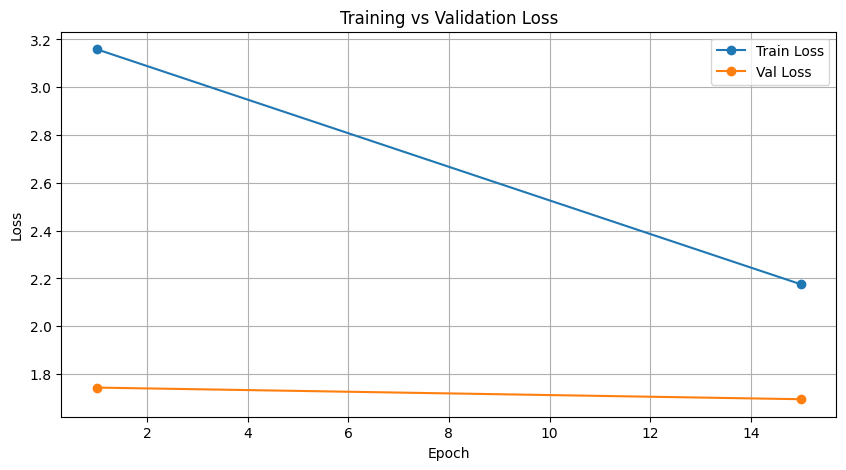

📁 Loss curve saved → /content/drive/MyDrive/Webtoon_Models/resnet_loss_curve.png


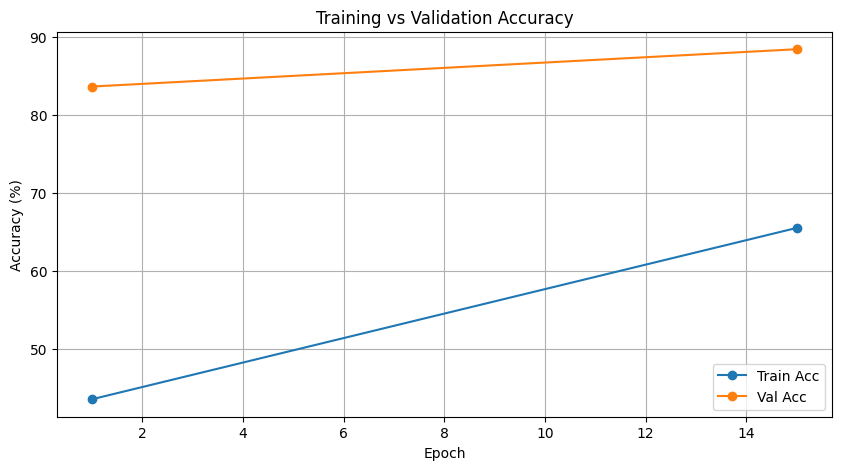

📁 Accuracy curve saved → /content/drive/MyDrive/Webtoon_Models/resnet_accuracy_curve.png


In [ ]:
import re
import matplotlib.pyplot as plt
import os

SAVE_DIR = "/content/drive/MyDrive/Webtoon_Models/"
os.makedirs(SAVE_DIR, exist_ok=True)

log_text = """
Device: cuda
Total images: 27870
Train=16722, Val=5574, Test=5574, Classes=340
🔥 Loaded 2차 모델 (strict=True)

=== Epoch 1/15 ===
Epoch 1 | Train Loss: 3.1593 | Train Acc: 43.60% | Val Loss: 1.7433 | Val Acc: 83.67%
...

=== Epoch 15/15 ===
Epoch 15 | Train Loss: 2.1752 | Train Acc: 65.55% | Val Loss: 1.6946 | Val Acc: 88.45%
🎯 Final Test Accuracy: 87.14%
Done.
"""

# ============================================
# 🔍 정규식 패턴 (네 로그에 완전 최적화)
# ============================================
pattern = r"Epoch\s+(\d+)\s*\|\s*Train Loss:\s*([\d\.]+)\s*\|\s*Train Acc:\s*([\d\.]+)%\s*\|\s*Val Loss:\s*([\d\.]+)\s*\|\s*Val Acc:\s*([\d\.]+)%"

matches = re.findall(pattern, log_text)

epochs = []
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for m in matches:
    epoch = int(m[0])
    train_loss = float(m[1])
    train_acc = float(m[2])
    val_loss = float(m[3])
    val_acc = float(m[4])

    epochs.append(epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

print("Parsed:", len(epochs), "epochs")

# ============================================
# 📊 Loss 그래프
# ============================================
plt.figure(figsize=(10,5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

loss_path = os.path.join(SAVE_DIR, "resnet_loss_curve.png")
plt.savefig(loss_path, dpi=300)
plt.show()
print(f"📁 Loss curve saved → {loss_path}")

# ============================================
# 📈 Accuracy 그래프
# ============================================
plt.figure(figsize=(10,5))
plt.plot(epochs, train_accs, marker='o', label='Train Acc')
plt.plot(epochs, val_accs, marker='o', label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

acc_path = os.path.join(SAVE_DIR, "resnet_accuracy_curve.png")
plt.savefig(acc_path, dpi=300)
plt.show()
print(f"📁 Accuracy curve saved → {acc_path}")



In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
from tqdm import tqdm

# ================================
# Config
# ================================
NAVER_ROOT_DIR = "/content/drive/MyDrive/Naver_Processed"
PRETRAINED_PATH = "/content/drive/MyDrive/Webtoon_Models/webtoon_resnet50_v3.pt"
EMBEDDING_OUTPUT_PATH = "/content/drive/MyDrive/Webtoon_Models/naver_embeddings.npz"

BATCH_SIZE = 32
NUM_WORKERS = 0
NUM_CLASSES = 340
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================================
# Dataset 정의
# ================================
class WebtoonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for work_id in sorted(os.listdir(root_dir)):
            work_path = os.path.join(root_dir, work_id)
            if not os.path.isdir(work_path):
                continue

            for bundle in sorted(os.listdir(work_path)):
                bundle_path = os.path.join(work_path, bundle)
                if not os.path.isdir(bundle_path):
                    continue

                for fname in sorted(os.listdir(bundle_path)):
                    if fname.lower().endswith(('.jpg', '.png', '.jpeg', '.webp')):
                        # Store (path, work_id) tuple
                        self.samples.append((os.path.join(bundle_path, fname), work_id))

        self.classes = sorted(list({label for _, label in self.samples}))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        print(f"📊 Dataset Statistics:")
        print(f"   Total images: {len(self.samples)}")
        print(f"   Total works: {len(self.classes)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        # Return image, label_idx, and original index for path tracking
        return img, self.class_to_idx[label], idx

# ================================
# Transform 정의
# ================================
val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

# ================================
# Model 정의 + pretrained weights 로드
# ================================
model = models.resnet50(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)
model = model.to(DEVICE)

# load pretrained
ck = torch.load(PRETRAINED_PATH, map_location=DEVICE)
try:
    model.load_state_dict(ck, strict=True)
    print("🔥 Loaded fine-tuned model weights (strict)")
except Exception as e:
    print("⚠️ Failed strict load, trying non-strict")
    model.load_state_dict(ck, strict=False)

model.eval()
for p in model.parameters():
    p.requires_grad = False

# ================================
# FeatureExtractor (avgpool flatten)
# ================================
class FeatureExtractor(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.features = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4,
            backbone.avgpool
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # B x 2048
        return x

extractor = FeatureExtractor(model).to(DEVICE)
extractor.eval()

# ================================
# DataLoader
# ================================
full_dataset = WebtoonDataset(NAVER_ROOT_DIR, transform=val_transform)
loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ================================
# Extract embeddings with correct path tracking
# ================================
all_embeddings = []
all_labels = []
all_paths = []
all_work_ids = []

with torch.no_grad():
    for imgs, labels, indices in tqdm(loader, desc="Extracting embeddings"):
        imgs = imgs.to(DEVICE)
        feats = extractor(imgs)

        all_embeddings.append(feats.cpu().numpy())
        all_labels.append(labels.numpy())

        # Use actual indices to get correct paths and work_ids
        for idx in indices:
            path, work_id = full_dataset.samples[idx]
            all_paths.append(path)
            all_work_ids.append(work_id)

# concatenate
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_paths = np.array(all_paths)
all_work_ids = np.array(all_work_ids)

# Verify unique works
unique_works = np.unique(all_work_ids)
print(f"\n✅ Extracted embeddings for {len(unique_works)} unique works")
print(f"   Total images: {len(all_embeddings)}")
print(f"   Sample works: {list(unique_works[:10])}")

# save with work_ids included
np.savez(EMBEDDING_OUTPUT_PATH,
         embeddings=all_embeddings,
         labels=all_labels,
         paths=all_paths,
         work_ids=all_work_ids)

print(f"\n✅ Saved embeddings to {EMBEDDING_OUTPUT_PATH}")
print(f"   Embedding shape: {all_embeddings.shape}")
print(f"   Saved fields: embeddings, labels, paths, work_ids")

🔥 Loaded fine-tuned model weights (strict)
📊 Dataset Statistics:
   Total images: 27870
   Total works: 340


Extracting embeddings: 100%|██████████| 871/871 [3:13:24<00:00, 13.32s/it]



✅ Extracted embeddings for 340 unique works
   Total images: 27870
   Sample works: [np.str_('FRIDAY_1초'), np.str_('FRIDAY_3분의 1이 없어도'), np.str_('FRIDAY_A.I. 닥터'), np.str_('FRIDAY_가장 썩은 것을 줄게'), np.str_('FRIDAY_개집사'), np.str_('FRIDAY_광마회귀'), np.str_('FRIDAY_괴물 의상실'), np.str_('FRIDAY_구야는 신입'), np.str_('FRIDAY_그 기사가 레이디로 사는 법'), np.str_('FRIDAY_그거 사랑 아니야')]

✅ Saved embeddings to /content/drive/MyDrive/Webtoon_Models/naver_embeddings.npz
   Embedding shape: (27870, 2048)
   Saved fields: embeddings, labels, paths, work_ids


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
from tqdm import tqdm

# ================================
# Config
# ================================
KAKAO_ROOT_DIR = "/content/drive/MyDrive/Kakao_Processed"
PRETRAINED_PATH = "/content/drive/MyDrive/Webtoon_Models/webtoon_resnet50_v3.pt"
EMBEDDING_OUTPUT_PATH = "/content/drive/MyDrive/Webtoon_Models/kakao_embeddings.npz"

BATCH_SIZE = 32
NUM_WORKERS = 0
NUM_CLASSES = 340
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================================
# Dataset
# ================================
class KakaoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for work_id in sorted(os.listdir(root_dir)):
            work_path = os.path.join(root_dir, work_id)
            if not os.path.isdir(work_path):
                continue

            for bundle in sorted(os.listdir(work_path)):
                bundle_path = os.path.join(work_path, bundle)
                if not os.path.isdir(bundle_path):
                    continue

                for fname in sorted(os.listdir(bundle_path)):
                    if fname.lower().endswith(('.jpg', '.png', '.jpeg', '.webp')):
                        # Store (path, work_id) tuple
                        self.samples.append((os.path.join(bundle_path, fname), work_id))

        # Get unique work_ids
        self.work_ids = sorted(list({work_id for _, work_id in self.samples}))

        print(f"📊 Kakao Dataset Statistics:")
        print(f"   Total images: {len(self.samples)}")
        print(f"   Total works: {len(self.work_ids)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, work_id = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        # Return image, work_id, and index for tracking
        return img, work_id, idx

# ================================
# Transform
# ================================
val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

# ================================
# Model + Pretrained weights
# ================================
model = models.resnet50(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)
model = model.to(DEVICE)

ck = torch.load(PRETRAINED_PATH, map_location=DEVICE)
try:
    model.load_state_dict(ck, strict=True)
    print("🔥 Loaded fine-tuned model weights (strict)")
except Exception:
    print("⚠️ Failed strict load, trying non-strict")
    model.load_state_dict(ck, strict=False)

model.eval()
for p in model.parameters():
    p.requires_grad = False

# ================================
# Feature extractor
# ================================
class FeatureExtractor(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.features = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4,
            backbone.avgpool
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

extractor = FeatureExtractor(model).to(DEVICE)
extractor.eval()

# ================================
# DataLoader
# ================================
dataset = KakaoDataset(KAKAO_ROOT_DIR, transform=val_transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ================================
# Extract embeddings with correct tracking
# ================================
all_embeddings = []
all_paths = []
all_work_ids = []

with torch.no_grad():
    for imgs, work_ids_batch, indices in tqdm(loader, desc="Extracting Kakao embeddings"):
        imgs = imgs.to(DEVICE)
        feats = extractor(imgs)

        all_embeddings.append(feats.cpu().numpy())

        # Use actual indices to get correct paths and work_ids
        for idx in indices:
            path, work_id = dataset.samples[idx]
            all_paths.append(path)
            all_work_ids.append(work_id)

# concatenate
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_paths = np.array(all_paths)
all_work_ids = np.array(all_work_ids)

# Verify unique works
unique_works = np.unique(all_work_ids)
print(f"\n✅ Extracted embeddings for {len(unique_works)} unique Kakao works")
print(f"   Total images: {len(all_embeddings)}")
print(f"   Sample works: {list(unique_works[:10])}")

# save as npz with work_ids
np.savez(EMBEDDING_OUTPUT_PATH,
         embeddings=all_embeddings,
         paths=all_paths,
         work_ids=all_work_ids)

print(f"\n✅ Saved Kakao embeddings to {EMBEDDING_OUTPUT_PATH}")
print(f"   Embedding shape: {all_embeddings.shape}")
print(f"   Saved fields: embeddings, paths, work_ids")

🔥 Loaded fine-tuned model weights (strict)
📊 Kakao Dataset Statistics:
   Total images: 731
   Total works: 13


Extracting Kakao embeddings: 100%|██████████| 23/23 [41:36<00:00, 108.54s/it]


✅ Extracted embeddings for 13 unique Kakao works
   Total images: 731
   Sample works: [np.str_('FRIDAY_불청객과 춤을'), np.str_('FRIDAY_아크'), np.str_('MONDAY_BLOCK'), np.str_('MONDAY_무지개다리 파수꾼'), np.str_('MONDAY_붉게 물들면'), np.str_('SATURDAY_부기영화'), np.str_('SUNDAY_정령군주'), np.str_('THURSDAY_관존 이강진'), np.str_('THURSDAY_백의사자'), np.str_('TUESDAY_버그 트레인')]

✅ Saved Kakao embeddings to /content/drive/MyDrive/Webtoon_Models/kakao_embeddings.npz
   Embedding shape: (731, 2048)
   Saved fields: embeddings, paths, work_ids


Naver embeddings: (27870, 2048)
Kakao embeddings: (731, 2048)
Top-5 most similar Naver indices for first 5 Kakao images:
Kakao 0: [17831 17847   519 17854 17849] (cosine sims: [0.85134196 0.8505528  0.84840095 0.84823406 0.8391803 ])
Kakao 1: [ 5678  2430 21368  8333  5781] (cosine sims: [0.8502996 0.8491075 0.841441  0.8409444 0.8373641])
Kakao 2: [27346 21585 27328  3410  3432] (cosine sims: [0.8636813  0.8635573  0.8544102  0.8463016  0.84608203])
Kakao 3: [17979 24874 17948  3437  4003] (cosine sims: [0.8943818  0.8882928  0.88011825 0.87212306 0.86739445])
Kakao 4: [17108 17093 15226 17078 17110] (cosine sims: [0.86127895 0.8604495  0.8599013  0.8595319  0.85418016])


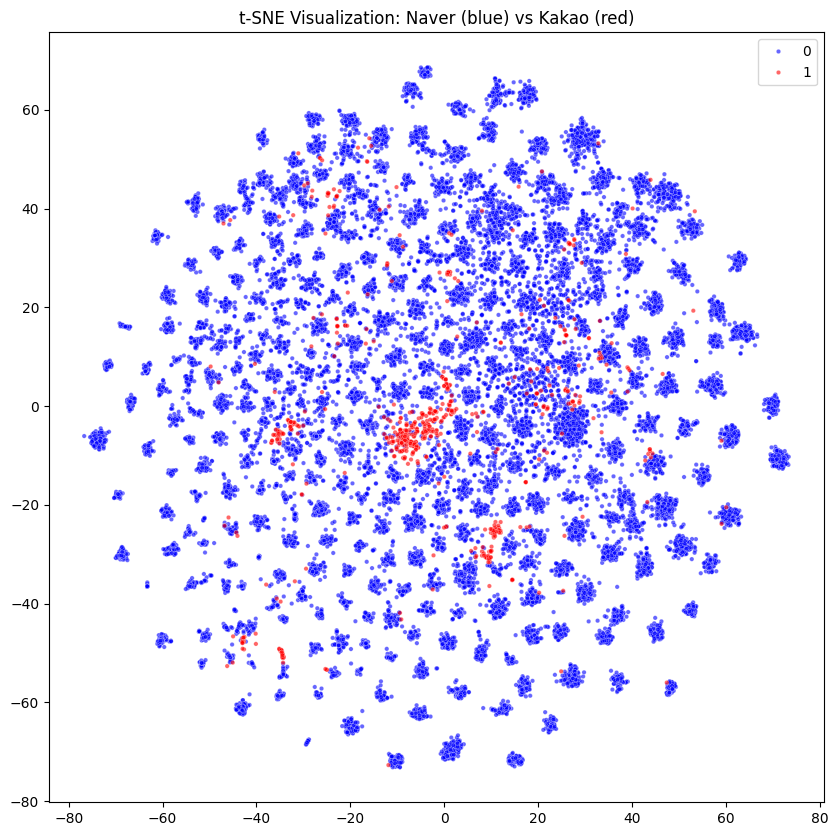

Kakao -> Naver class similarity shape: (731, 340)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import seaborn as sns

# ==========================
# 1) Load embeddings
# ==========================
naver_data = np.load("/content/drive/MyDrive/Webtoon_Models/naver_embeddings.npz")
kakao_data = np.load("/content/drive/MyDrive/Webtoon_Models/kakao_embeddings.npz")

naver_embeddings = naver_data['embeddings']   # (N_naver, 2048)
naver_labels = naver_data['labels']           # (N_naver,)
naver_paths = naver_data['paths']

kakao_embeddings = kakao_data['embeddings']   # (N_kakao, 2048)
kakao_paths = kakao_data['paths']

print("Naver embeddings:", naver_embeddings.shape)
print("Kakao embeddings:", kakao_embeddings.shape)

# ==========================
# 2) Cosine similarity (Kakao -> Naver)
# ==========================
similarity_matrix = cosine_similarity(kakao_embeddings, naver_embeddings)
# similarity_matrix shape: (N_kakao, N_naver)

# 예시: 각 카카오 이미지의 네이버 가장 유사 이미지 top-5
top_k = 5
top_indices = np.argsort(similarity_matrix, axis=1)[:, -top_k:][:, ::-1]

print("Top-5 most similar Naver indices for first 5 Kakao images:")
for i in range(5):
    print(f"Kakao {i}: {top_indices[i]} (cosine sims: {similarity_matrix[i, top_indices[i]]})")

# ==========================
# 3) t-SNE 시각화
# ==========================
# Naver: blue, Kakao: red
all_embeddings = np.concatenate([naver_embeddings, kakao_embeddings], axis=0)
labels = np.array([0]*len(naver_embeddings) + [1]*len(kakao_embeddings))

tsne = TSNE(n_components=2, perplexity=50, learning_rate=200, random_state=42)
emb_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(10,10))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=labels, palette=['blue','red'], s=10, alpha=0.6)
plt.title("t-SNE Visualization: Naver (blue) vs Kakao (red)")
plt.show()

# ==========================
# 4) Class-wise similarity (optional)
# ==========================
# 네이버 클래스별 평균 embedding 계산
naver_class_means = {}
for cls in np.unique(naver_labels):
    idxs = np.where(naver_labels == cls)[0]
    nmean = naver_embeddings[idxs].mean(axis=0)
    naver_class_means[cls] = nmean

# 각 카카오 이미지와 네이버 클래스 평균 유사도
kakao_to_class_sim = []
for k_emb in kakao_embeddings:
    sims = [cosine_similarity(k_emb.reshape(1,-1), c_emb.reshape(1,-1))[0,0]
            for c_emb in naver_class_means.values()]
    kakao_to_class_sim.append(sims)

kakao_to_class_sim = np.array(kakao_to_class_sim)
print("Kakao -> Naver class similarity shape:", kakao_to_class_sim.shape)


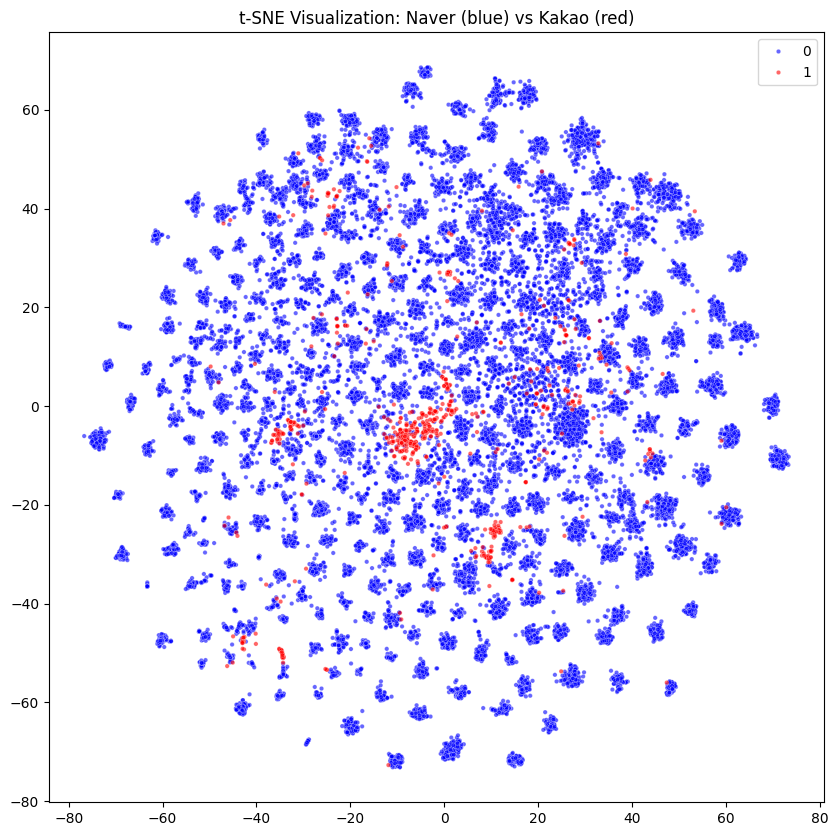

📁 t-SNE image saved → /content/drive/MyDrive/Webtoon_Embeddings/analysis/tsne_naver_kakao.png


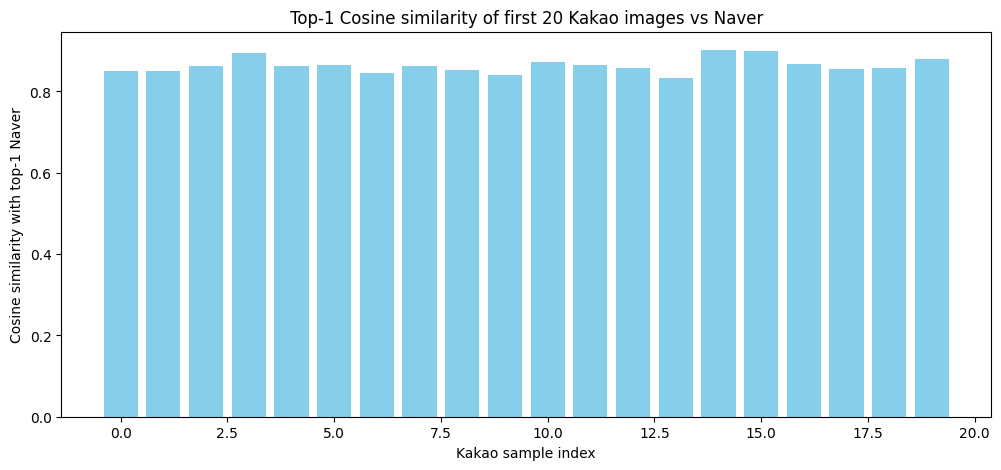

📁 Cosine similarity image saved → /content/drive/MyDrive/Webtoon_Embeddings/analysis/kakao_top1_similarity.png


In [ ]:
import os

# ==============================
# 0) Save directory
# ==============================
SAVE_DIR = "/content/drive/MyDrive/Webtoon_Embeddings/analysis"
os.makedirs(SAVE_DIR, exist_ok=True)

# ==============================
# 1) t-SNE 시각화 저장
# ==============================
plt.figure(figsize=(10,10))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=labels, palette=['blue','red'], s=10, alpha=0.6)
plt.title("t-SNE Visualization: Naver (blue) vs Kakao (red)")
tsne_path = os.path.join(SAVE_DIR, "tsne_naver_kakao.png")
plt.savefig(tsne_path, dpi=300)
plt.show()
print(f"📁 t-SNE image saved → {tsne_path}")

# ==============================
# 2) Top-5 cosine similarity 시각화 예시 저장
# ==============================
# 첫 20개의 Kakao 이미지와 가장 유사한 Naver 이미지 top-5 평균 similarity 시각화
num_samples = min(20, len(kakao_embeddings))
top1_indices = top_indices[:num_samples, 0]  # 각 Kakao 이미지의 top-1 Naver index
top1_sims = similarity_matrix[np.arange(num_samples), top1_indices]

plt.figure(figsize=(12,5))
plt.bar(range(num_samples), top1_sims, color='skyblue')
plt.xlabel("Kakao sample index")
plt.ylabel("Cosine similarity with top-1 Naver")
plt.title("Top-1 Cosine similarity of first 20 Kakao images vs Naver")
sim_path = os.path.join(SAVE_DIR, "kakao_top1_similarity.png")
plt.savefig(sim_path, dpi=300)
plt.show()
print(f"📁 Cosine similarity image saved → {sim_path}")


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import os
import unicodedata   # 🔥 추가됨

# ==========================
# Configuration
# ==========================
EMBEDDING_PATH = "/content/drive/MyDrive/Webtoon_Models/naver_embeddings.npz"

# ==========================
# Load embeddings
# ==========================
print("Loading embeddings...")
data = np.load(EMBEDDING_PATH)
embeddings = data['embeddings']  # (N, 2048)
labels = data['labels']
paths = data['paths']

print(f"Loaded {len(embeddings)} images")
print(f"Embedding shape: {embeddings.shape}")

# ==========================
# Extract work_id from paths (FIXED: Normalize to NFC)
# ==========================
def extract_work_id(path):
    path = path.replace("\\", "/")
    parts = path.split("/")

    for i, p in enumerate(parts):
        if "Naver_Processed" in p:
            if i+1 < len(parts):
                work_folder = parts[i+1]

                # 요일 prefix 삭제
                days = ["MONDAY_", "TUESDAY_", "WEDNESDAY_", "THURSDAY_",
                        "FRIDAY_", "SATURDAY_", "SUNDAY_"]

                for d in days:
                    if work_folder.startswith(d):
                        wid = work_folder[len(d):]
                        # 🔥 Normalize to NFC
                        return unicodedata.normalize("NFC", wid)

                # 요일 prefix 없는 경우
                return unicodedata.normalize("NFC", work_folder)
    return None


# Debug: first 10 paths
print("\n🔍 Debug: First 10 paths:")
for p in paths[:10]:
    print(" ", p)

# ==========================
# Build work index mapping
# ==========================
work_id_to_indices = {}
work_ids_ordered = []

for idx, p in enumerate(paths):
    wid = extract_work_id(p)
    if wid:
        if wid not in work_id_to_indices:
            work_id_to_indices[wid] = []
            work_ids_ordered.append(wid)
        work_id_to_indices[wid].append(idx)

print(f"\n✅ Found {len(work_id_to_indices)} works.")

print("\n🔍 Debug: First 10 extracted work_ids:")
for w in work_ids_ordered[:10]:
    print(" ", w)

# ==========================
# Compute average embeddings
# ==========================
work_embeddings = {}
for wid in work_ids_ordered:
    idxs = work_id_to_indices[wid]
    avg_emb = embeddings[idxs].mean(axis=0)
    work_embeddings[wid] = avg_emb

work_embedding_matrix = np.array([work_embeddings[w] for w in work_ids_ordered])
print(f"\nWork embedding matrix shape: {work_embedding_matrix.shape}")

# ==========================
# Recommendation engine
# ==========================
def recommend_similar_works(query_name, top_k=5):
    global work_ids_ordered, work_embedding_matrix

    # 🔥 Normalize query for Korean NFC stability
    normalized_query = unicodedata.normalize("NFC", query_name.replace(" ", ""))

    # 후보 검색
    candidates = [
        w for w in work_ids_ordered
        if normalized_query in unicodedata.normalize("NFC", w.replace(" ", ""))
    ]

    if not candidates:
        print(f"❌ 작품 '{query_name}' 을(를) 찾지 못했습니다.")
        return None, None

    matched_name = candidates[0]
    print(f"🔍 Interpreted as: {matched_name}")

    query_idx = work_ids_ordered.index(matched_name)
    query_vec = work_embedding_matrix[query_idx]

    sims = cosine_similarity([query_vec], work_embedding_matrix)[0]

    top_indices = sims.argsort()[::-1]
    top_indices = [i for i in top_indices if i != query_idx][:top_k]

    recommendations = [(work_ids_ordered[i], float(sims[i])) for i in top_indices]

    return matched_name, recommendations


# ==========================
# Example test
# ==========================
print("\n" + "="*60)
print("🔍 Testing recommendation for '소녀의 세계'")
print("="*60)

query = "소녀의 세계"
actual, recs = recommend_similar_works(query, top_k=5)

print(f"\n📌 Query interpreted as: {actual}")
print("\n✨ TOP 5 추천 웹툰:\n")
for i, (wid, score) in enumerate(recs, 1):
    print(f"  {i}. {wid:30s}  (similarity: {score:.4f})")

print("\n" + "="*60)
print("💡 Additional usage: get_recommendations('작품명')")
print("="*60)


# ==========================
# Public API
# ==========================
def get_recommendations(name, top_k=5):
    actual, recs = recommend_similar_works(name, top_k)
    print(f"\n📌 Query → '{actual}'")
    print(f"\n✨ TOP {top_k} Recommendations:\n")
    for i, (wid, score) in enumerate(recs, 1):
        print(f"  {i}. {wid:30s} (similarity: {score:.4f})")
    return recs


Loading embeddings...
Loaded 27870 images
Embedding shape: (27870, 2048)

🔍 Debug: First 10 paths:
  /content/drive/MyDrive/Naver_Processed/FRIDAY_1초/bundle_01/16_26.jpg
  /content/drive/MyDrive/Naver_Processed/FRIDAY_1초/bundle_01/16_33.jpg
  /content/drive/MyDrive/Naver_Processed/FRIDAY_1초/bundle_01/16_41.jpg
  /content/drive/MyDrive/Naver_Processed/FRIDAY_1초/bundle_01/16_9.jpg
  /content/drive/MyDrive/Naver_Processed/FRIDAY_1초/bundle_01/17_19.jpg
  /content/drive/MyDrive/Naver_Processed/FRIDAY_1초/bundle_01/17_22.jpg
  /content/drive/MyDrive/Naver_Processed/FRIDAY_1초/bundle_01/17_26.jpg
  /content/drive/MyDrive/Naver_Processed/FRIDAY_1초/bundle_01/17_45.jpg
  /content/drive/MyDrive/Naver_Processed/FRIDAY_1초/bundle_01/17_8.jpg
  /content/drive/MyDrive/Naver_Processed/FRIDAY_1초/bundle_01/18_24.jpg

✅ Found 328 works.

🔍 Debug: First 10 extracted work_ids:
  1초
  3분의 1이 없어도
  A.I. 닥터
  가장 썩은 것을 줄게
  개집사
  광마회귀
  괴물 의상실
  구야는 신입
  그 기사가 레이디로 사는 법
  그거 사랑 아니야

Work embedding matri

In [ ]:
import numpy as np
import tensorflow as tf # 또는 import torch (사용하신 프레임워크에 따라)
from google.colab import drive

# 1. 구글 드라이브 마운트 (이미 되어 있다면 생략 가능)
drive.mount('/content/drive')

# 2. 파일 경로 설정
file_path = '/content/drive/MyDrive/Webtoon_Models/naver_embeddings.npz'

try:
    # 3. .npz 파일 로드
    data = np.load(file_path)

    # 4. 파일 내부의 키(Key) 확인
    # npz는 딕셔너리처럼 여러 배열을 저장합니다. 어떤 이름으로 저장됐는지 확인해야 합니다.
    print("저장된 키 목록:", data.files)

    # 5. 임베딩 벡터 추출
    # 보통 'embeddings', 'features', 'vectors', 'arr_0' 등의 이름으로 저장됩니다.
    # 가장 유력한 키를 찾아서 할당합니다.
    if 'embeddings' in data.files:
        embedding_vectors = data['embeddings']
    elif 'vectors' in data.files:
        embedding_vectors = data['vectors']
    else:
        # 키 이름을 모를 경우 첫 번째 배열을 가져옵니다.
        first_key = data.files[0]
        embedding_vectors = data[first_key]
        print(f"'{first_key}' 키의 데이터를 임베딩 벡터로 사용합니다.")

    # 6. 차원 확인 (가장 중요!)
    print(f"\n임베딩 벡터 형태(Shape): {embedding_vectors.shape}")

    # [해석 가이드]
    # Shape이 (N, D) 형태여야 합니다.
    # N: 데이터 개수 (웹툰 이미지 수)
    # D: 차원 수 (예: 128, 256, 512, 1024, 2048 등)
    # 만약 D가 장르 개수(예: 10, 15)와 같다면 그것은 임베딩이 아니라 분류 결과(Logits)입니다.

    feature_dim = embedding_vectors.shape[1]
    if feature_dim > 50:
        print("✅ 확인됨: 이 데이터는 Classification Layer가 제거된 임베딩 벡터입니다.")
    else:
        print("⚠️ 경고: 차원 수가 작습니다. 혹시 분류 결과(확률)가 저장된 것이 아닌지 확인하세요.")

    # -------------------------------------------------------
    # (선택) 이 임베딩 벡터를 사용하여 유사도 검색 등을 수행하는 예시
    # -------------------------------------------------------
    # 예: 첫 번째 웹툰과 가장 유사한 웹툰 찾기 (코사인 유사도)
    from sklearn.metrics.pairwise import cosine_similarity

    # 첫 번째 이미지의 벡터
    target_vector = embedding_vectors[0].reshape(1, -1)

    # 전체와의 유사도 계산
    similarities = cosine_similarity(target_vector, embedding_vectors)

    # 자기 자신을 제외하고 가장 유사한 인덱스 찾기
    similar_indices = similarities.argsort()[0][::-1] # 내림차순 정렬

    print(f"\n첫 번째 데이터와 가장 유사한 인덱스 Top 3: {similar_indices[1:4]}")

except FileNotFoundError:
    print("❌ 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요.")
except Exception as e:
    print(f"❌ 오류 발생: {e}")

Mounted at /content/drive
저장된 키 목록: ['embeddings', 'labels', 'paths', 'work_ids']

임베딩 벡터 형태(Shape): (27870, 2048)
✅ 확인됨: 이 데이터는 Classification Layer가 제거된 임베딩 벡터입니다.

첫 번째 데이터와 가장 유사한 인덱스 Top 3: [5 2 8]


In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,794 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and dire

📂 데이터를 로드하고 정규화를 수행합니다...
✅ 메타데이터 328개 로드 완료.
🔗 데이터 병합 중...
✅ 병합 완료! 총 26773개의 이미지가 매칭되었습니다.
🎨 t-SNE 차원 축소 시작...


/tmp/ipython-input-1325607894.py:143: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/tmp/ipython-input-1325607894.py:146: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.savefig(SAVE_IMAGE_PATH, dpi=300, bbox_inches='tight')


💾 그래프가 저장되었습니다: /content/drive/MyDrive/Webtoon_Models/naver_tsne_result.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


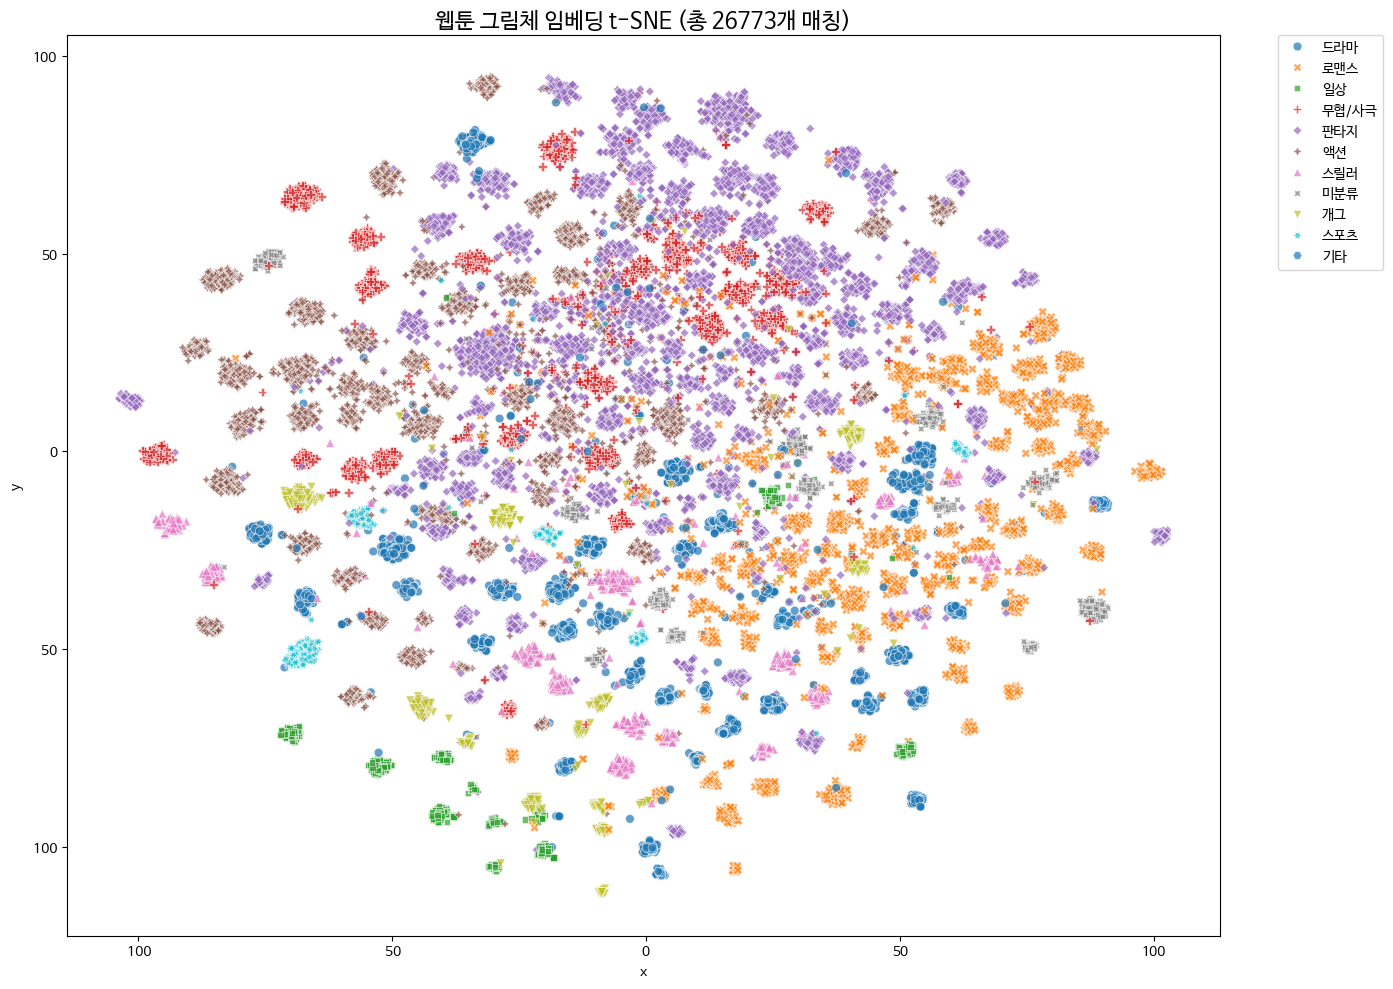

🎉 시각화 완료!


In [2]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import unicodedata # 💡 핵심: 유니코드 정규화 라이브러리

# 1. 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# ----------------------------------------------------------
# 파일 경로
# ----------------------------------------------------------
BASE_DIR = '/content/drive/MyDrive/Webtoon_Models'
NPZ_PATH = f'{BASE_DIR}/naver_embeddings.npz'
JSON_PATH = f'{BASE_DIR}/naver_metadata.json'
SAVE_IMAGE_PATH = f'{BASE_DIR}/naver_tsne_result.png' # 💾 저장할 이미지 경로

# ----------------------------------------------------------
# 💡 문자열 정규화 함수 (핵심 해결책)
# ----------------------------------------------------------
def normalize_text(text):
    """한글 자모 분리 현상 등을 통일시키는 함수 (NFC 표준화)"""
    if not isinstance(text, str):
        text = str(text)
    # 유니코드 정규화 (NFC: 글자를 하나로 합침)
    text = unicodedata.normalize('NFC', text)
    return text.strip()

# ----------------------------------------------------------
# 2. 데이터 로드
# ----------------------------------------------------------
print("📂 데이터를 로드하고 정규화를 수행합니다...")

# (1) 임베딩 로드
npz_data = np.load(NPZ_PATH)
embeddings = npz_data['embeddings']
work_ids_npz = npz_data['work_ids']

# (2) 메타데이터 로드
with open(JSON_PATH, 'r', encoding='utf-8') as f:
    meta_data = json.load(f)

# ----------------------------------------------------------
# 3. 매칭 사전 생성 (정규화 적용!)
# ----------------------------------------------------------
title_to_genre = {}

for item in meta_data:
    # 💡 제목을 정규화해서 저장
    raw_title = item['title']
    clean_title = normalize_text(raw_title)

    # 장르 처리
    if item.get('genre') and len(item['genre']) > 0:
        genre = item['genre'][0]
    else:
        genre = "미분류"

    title_to_genre[clean_title] = genre

print(f"✅ 메타데이터 {len(title_to_genre)}개 로드 완료.")

# ----------------------------------------------------------
# 4. 데이터 병합
# ----------------------------------------------------------
print("🔗 데이터 병합 중...")

valid_embeddings = []
valid_genres = []
match_count = 0

for i, raw_id in enumerate(work_ids_npz):
    # 1. NPZ ID에서 제목 추출 ('FRIDAY_1초' -> '1초')
    id_str = str(raw_id)
    if '_' in id_str:
        extracted_title = id_str.split('_', 1)[1]
    else:
        extracted_title = id_str

    # 2. 💡 추출한 제목도 정규화!
    clean_key = normalize_text(extracted_title)

    # 3. 매칭 확인
    if clean_key in title_to_genre:
        valid_embeddings.append(embeddings[i])
        valid_genres.append(title_to_genre[clean_key])
        match_count += 1

# 결과 변환
X = np.array(valid_embeddings)
y_genre = np.array(valid_genres)

print(f"✅ 병합 완료! 총 {match_count}개의 이미지가 매칭되었습니다.")

if match_count == 0:
    print("❌ 여전히 매칭 실패... 데이터를 확인해주세요.")
else:
    # ----------------------------------------------------------
    # 5. 시각화 (t-SNE)
    # ----------------------------------------------------------
    NUM_SAMPLES = 26773

    if len(X) > NUM_SAMPLES:
        print(f"⚡ {NUM_SAMPLES}개 샘플링 중...")
        indices = np.random.choice(len(X), NUM_SAMPLES, replace=False)
        X_sample = X[indices]
        genre_sample = y_genre[indices]
    else:
        X_sample = X
        genre_sample = y_genre

    # 상위 장르 정리 (상위 10개 외에는 '기타' 처리하여 그래프 가독성 높임)
    top_genres = pd.Series(genre_sample).value_counts().nlargest(10).index
    genre_sample_clean = np.where(np.isin(genre_sample, top_genres), genre_sample, '기타')

    print("🎨 t-SNE 차원 축소 시작...")
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
    X_2d = tsne.fit_transform(X_sample)

    # 시각화용 데이터프레임
    df_viz = pd.DataFrame({
        'x': X_2d[:, 0],
        'y': X_2d[:, 1],
        'Genre': genre_sample_clean
    })

    # 그래프 그리기
    plt.figure(figsize=(14, 10))
    sns.scatterplot(
        data=df_viz,
        x='x', y='y',
        hue='Genre',
        style='Genre',
        palette='tab10',
        alpha=0.7,
        s=40
    )

    plt.title(f'웹툰 그림체 임베딩 t-SNE (총 {match_count}개 매칭)', fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

    # 💾 [추가됨] 이미지 저장 로직
    plt.savefig(SAVE_IMAGE_PATH, dpi=300, bbox_inches='tight')
    print(f"💾 그래프가 저장되었습니다: {SAVE_IMAGE_PATH}")

    plt.show()

    print("🎉 시각화 완료!")

📂 데이터를 로드하고 매칭을 시작합니다...
✅ 데이터 준비 완료: 총 26773개 샘플
📊 분석 대상 장르: ['판타지', '액션', '로맨스', '드라마', '무협/사극', '스릴러', '미분류', '개그', '일상', '스포츠']

[1/3] Heatmap 생성 및 저장 중...
💾 Heatmap 저장 완료: /content/drive/MyDrive/Webtoon_Models//webtoon_style_heatmap.png


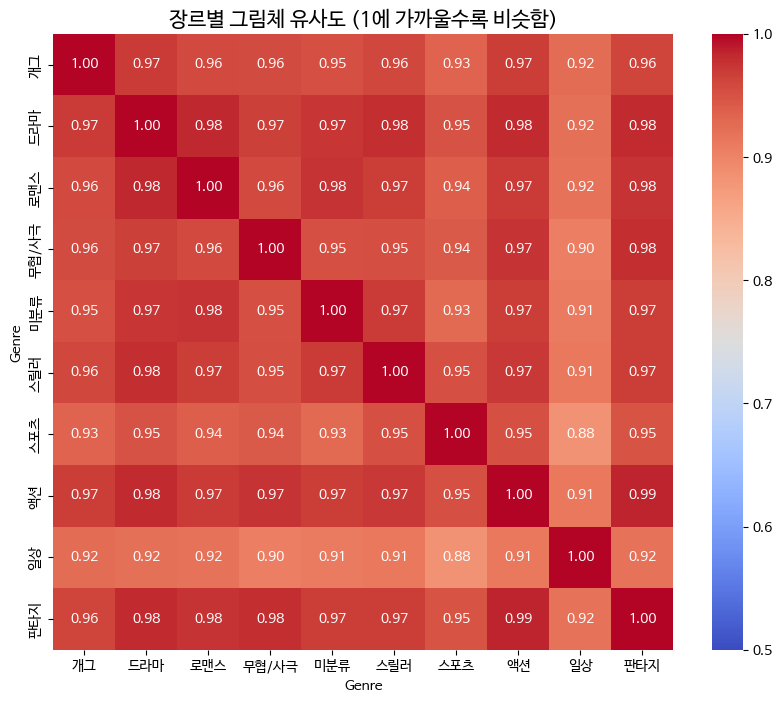


[2/3] Boxplot 생성 및 저장 중...


/tmp/ipython-input-676064196.py:128: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




💾 Boxplot 저장 완료: /content/drive/MyDrive/Webtoon_Models//webtoon_style_boxplot.png


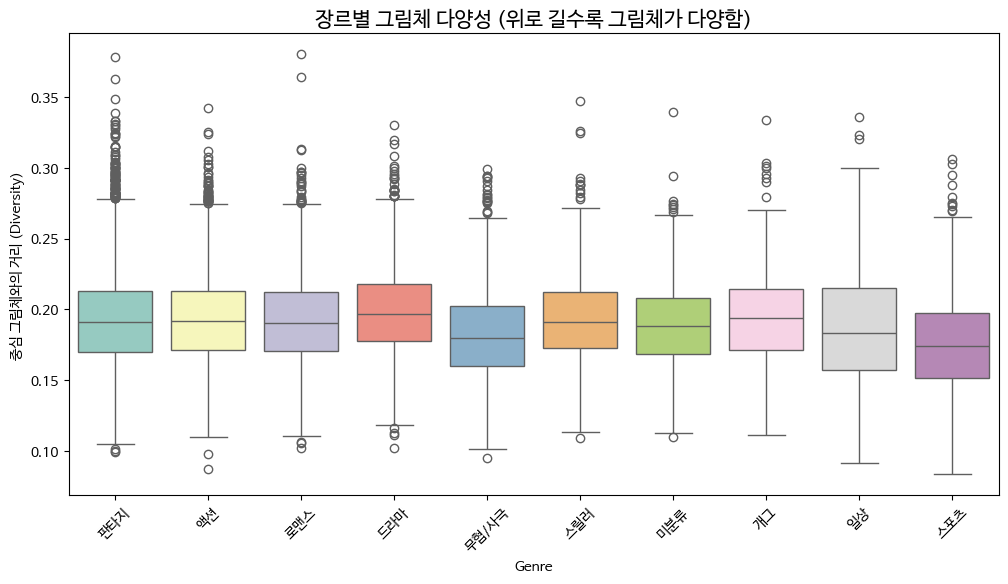


[3/3] t-SNE 계산 및 인터랙티브 그래프 생성 중... (데이터 26773개)
💾 인터랙티브 그래프 저장 완료: /content/drive/MyDrive/Webtoon_Models//webtoon_tsne_interactive.html



🎉 모든 작업이 완료되었습니다!


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import unicodedata
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

# 폰트 설정 (한글 깨짐 방지)
plt.rc('font', family='NanumBarunGothic')

# ---------------------------------------------------------
# 0. 설정 및 파일 경로 정의
# ---------------------------------------------------------
BASE_DIR = '/content/drive/MyDrive/Webtoon_Models/'
NPZ_PATH = f'{BASE_DIR}/naver_embeddings.npz'
JSON_PATH = f'{BASE_DIR}naver_metadata.json'

# 💾 저장할 파일 경로들
SAVE_HEATMAP_PATH = f'{BASE_DIR}/webtoon_style_heatmap.png'
SAVE_BOXPLOT_PATH = f'{BASE_DIR}/webtoon_style_boxplot.png'
SAVE_INTERACTIVE_PATH = f'{BASE_DIR}/webtoon_tsne_interactive.html'

def normalize_text(text):
    """한글 자모 분리 현상 통일 (NFC)"""
    if not isinstance(text, str):
        text = str(text)
    return unicodedata.normalize('NFC', text).strip()

print("📂 데이터를 로드하고 매칭을 시작합니다...")

# ---------------------------------------------------------
# 1. 데이터 로드 및 매칭
# ---------------------------------------------------------
npz_data = np.load(NPZ_PATH)
embeddings = npz_data['embeddings']
work_ids_npz = npz_data['work_ids']

with open(JSON_PATH, 'r', encoding='utf-8') as f:
    meta_data = json.load(f)

# 매칭 사전 생성
title_to_genre = {}
for item in meta_data:
    clean_title = normalize_text(item['title'])
    genre = item['genre'][0] if item.get('genre') and len(item['genre']) > 0 else "미분류"
    title_to_genre[clean_title] = genre

# 데이터 병합
valid_embeddings = []
valid_genres = []
valid_titles = []

for i, raw_id in enumerate(work_ids_npz):
    id_str = str(raw_id)
    extracted_title = id_str.split('_', 1)[1] if '_' in id_str else id_str
    clean_key = normalize_text(extracted_title)

    if clean_key in title_to_genre:
        valid_embeddings.append(embeddings[i])
        valid_genres.append(title_to_genre[clean_key])
        valid_titles.append(clean_key)

X = np.array(valid_embeddings)
y_genre = np.array(valid_genres)
y_title = np.array(valid_titles)

print(f"✅ 데이터 준비 완료: 총 {len(X)}개 샘플")

# 데이터프레임 생성
df_full = pd.DataFrame(X)
df_full['Genre'] = y_genre
df_full['Title'] = y_title

# 상위 10개 장르 추출
top_10_genres = df_full['Genre'].value_counts().nlargest(10).index
df_top = df_full[df_full['Genre'].isin(top_10_genres)].copy()
embedding_cols = list(range(X.shape[1])) # 임베딩 컬럼 인덱스

print(f"📊 분석 대상 장르: {list(top_10_genres)}")

# ---------------------------------------------------------
# 🎨 [1] Heatmap: 장르별 그림체 유사도 (저장 포함)
# ---------------------------------------------------------
print("\n[1/3] Heatmap 생성 및 저장 중...")

# 각 장르별 평균 벡터(Centroid) 계산
genre_centroids = df_top.groupby('Genre')[embedding_cols].mean()

# 코사인 유사도 계산
similarity_matrix = cosine_similarity(genre_centroids)
df_sim = pd.DataFrame(similarity_matrix, index=genre_centroids.index, columns=genre_centroids.index)

plt.figure(figsize=(10, 8))
sns.heatmap(df_sim, annot=True, fmt=".2f", cmap="coolwarm", vmin=0.5, vmax=1.0)
plt.title("장르별 그림체 유사도 (1에 가까울수록 비슷함)", fontsize=15)

# 💾 저장
plt.savefig(SAVE_HEATMAP_PATH, dpi=300, bbox_inches='tight')
print(f"💾 Heatmap 저장 완료: {SAVE_HEATMAP_PATH}")
plt.show()

# ---------------------------------------------------------
# 🎨 [2] Boxplot: 장르별 그림체 다양성 (저장 포함)
# ---------------------------------------------------------
print("\n[2/3] Boxplot 생성 및 저장 중...")

distances = []
genres = []

for genre in top_10_genres:
    # 해당 장르 데이터만 추출
    genre_data = df_top[df_top['Genre'] == genre][embedding_cols]
    centroid = genre_centroids.loc[genre].values.reshape(1, -1)

    # 중심과의 거리 계산 (1 - 유사도)
    sims = cosine_similarity(genre_data, centroid)
    dists = 1 - sims

    distances.extend(dists.flatten())
    genres.extend([genre] * len(dists))

df_dist = pd.DataFrame({'Genre': genres, 'Style_Diversity': distances})

plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='Style_Diversity', data=df_dist, palette="Set3")
plt.title("장르별 그림체 다양성 (위로 길수록 그림체가 다양함)", fontsize=15)
plt.ylabel("중심 그림체와의 거리 (Diversity)")
plt.xticks(rotation=45)

# 💾 저장
plt.savefig(SAVE_BOXPLOT_PATH, dpi=300, bbox_inches='tight')
print(f"💾 Boxplot 저장 완료: {SAVE_BOXPLOT_PATH}")
plt.show()

# ---------------------------------------------------------
# 🎨 [3] Interactive Plotly (전체 데이터, 저장 포함)
# ---------------------------------------------------------
print(f"\n[3/3] t-SNE 계산 및 인터랙티브 그래프 생성 중... (데이터 {len(df_full)}개)")

# t-SNE 계산 (전체 데이터 사용)
X_sample = df_full[embedding_cols].values
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', perplexity=30)
X_2d = tsne.fit_transform(X_sample)

df_full['x'] = X_2d[:, 0]
df_full['y'] = X_2d[:, 1]

# 상위 10개 외에는 '기타'로 분류
df_full['Genre_Clean'] = df_full['Genre'].apply(lambda x: x if x in top_10_genres else '기타')

# 그래프 생성
fig = px.scatter(
    df_full,
    x='x', y='y',
    color='Genre_Clean',
    hover_data=['Title', 'Genre'], # 마우스 오버 시 정보 표시
    title=f"웹툰 그림체 지도 (전체 데이터 {len(df_full)}개)",
    opacity=0.6,
    template="plotly_white",
    width=1000, height=800,
    render_mode='webgl' # 대량 데이터 가속
)

fig.update_traces(marker=dict(size=4))

# 💾 HTML 파일로 저장 (인터랙티브 기능 유지)
fig.write_html(SAVE_INTERACTIVE_PATH)
print(f"💾 인터랙티브 그래프 저장 완료: {SAVE_INTERACTIVE_PATH}")

fig.show()

print("\n🎉 모든 작업이 완료되었습니다!")